## Modeling to Predict Credit Limit using Classification Algorithms

### Jennifer Brosnahan, MPH

The purpose of this notebook is to compare and contrast 4 classification models for predicting categorized credit limit based on demographic and financial history features. Feature selection and tuning will be utilized to see which classification algorithm comes out on top.

In [1]:
#import libraries
#numpy, pandas, scipy, math, matplotlib
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

#helpers
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

#estimators
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#model metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#visualizing Trees
import six
from six import StringIO
from IPython.display import Image
from sklearn import tree
from sklearn.tree import export_graphviz
import pydotplus

### Reading dataset using Pandas

In [2]:
credit = pd.read_excel(r'C:\Users\jlbro\OneDrive\C2T3\credit.xlsx')
credit.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_4,age_6
0,20000,2,2,1,24,2,2,0,0,0,...,0,0,689,0,0,0,0,1,0,0
1,120000,2,2,2,26,0,2,0,0,0,...,3261,0,1000,1000,1000,0,2000,1,0,0
2,90000,2,2,2,34,0,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0,1,2
3,50000,2,2,1,37,0,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,0,2,3
4,50000,1,2,1,57,0,0,0,0,0,...,19131,2000,36681,10000,9000,689,679,0,3,5


In [3]:
#examining structure
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29965 entries, 0 to 29964
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  29965 non-null  int64
 1   SEX        29965 non-null  int64
 2   EDUCATION  29965 non-null  int64
 3   MARRIAGE   29965 non-null  int64
 4   AGE        29965 non-null  int64
 5   PAY_1      29965 non-null  int64
 6   PAY_2      29965 non-null  int64
 7   PAY_3      29965 non-null  int64
 8   PAY_4      29965 non-null  int64
 9   PAY_5      29965 non-null  int64
 10  PAY_6      29965 non-null  int64
 11  BILL_AMT1  29965 non-null  int64
 12  BILL_AMT2  29965 non-null  int64
 13  BILL_AMT3  29965 non-null  int64
 14  BILL_AMT4  29965 non-null  int64
 15  BILL_AMT5  29965 non-null  int64
 16  BILL_AMT6  29965 non-null  int64
 17  PAY_AMT1   29965 non-null  int64
 18  PAY_AMT2   29965 non-null  int64
 19  PAY_AMT3   29965 non-null  int64
 20  PAY_AMT4   29965 non-null  int64
 21  PAY_AMT5   2

### Discretizing Target Variable Credit Limit to prep for Classification Modeling

In [4]:
# Discretizing 4 equal sized bins
credit['limit_4'] = pd.qcut(credit['LIMIT_BAL'], q=4)

le = LabelEncoder()
le.fit(credit['limit_4'])

le.classes_

array([Interval(9999.999, 50000.0, closed='right'),
       Interval(50000.0, 140000.0, closed='right'),
       Interval(140000.0, 240000.0, closed='right'),
       Interval(240000.0, 1000000.0, closed='right')], dtype=object)

In [5]:
credit['limit_4'] = le.transform(credit['limit_4'])

In [6]:
# Discretizing 5 equal sized bins
credit['limit_5'] = pd.qcut(credit['LIMIT_BAL'], q=5)

le = LabelEncoder()
le.fit(credit['limit_5'])

le.classes_

array([Interval(9999.999, 50000.0, closed='right'),
       Interval(50000.0, 100000.0, closed='right'),
       Interval(100000.0, 180000.0, closed='right'),
       Interval(180000.0, 270000.0, closed='right'),
       Interval(270000.0, 1000000.0, closed='right')], dtype=object)

In [7]:
credit['limit_5'] = le.transform(credit['limit_5'])

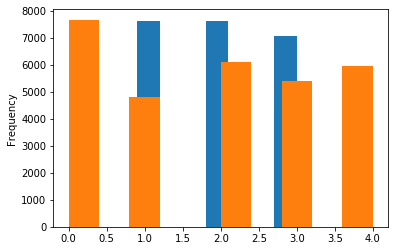

In [8]:
#Showing combined histogram of 4 and 5 equal-sized bins
credit['limit_4'].plot(kind='hist') 
credit['limit_5'].plot(kind='hist') 

In [9]:
# Discretizing 5 equal width bins
credit['limit_5width'] = pd.cut(credit['LIMIT_BAL'], bins=5)

le = LabelEncoder()
le.fit(credit['limit_5width'])

le.classes_

array([Interval(9010.0, 208000.0, closed='right'),
       Interval(208000.0, 406000.0, closed='right'),
       Interval(406000.0, 604000.0, closed='right'),
       Interval(604000.0, 802000.0, closed='right'),
       Interval(802000.0, 1000000.0, closed='right')], dtype=object)

In [10]:
credit['limit_5width'] = le.transform(credit['limit_5width'])
credit.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_4,age_6,limit_4,limit_5,limit_5width
0,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,120000,2,2,2,26,0,2,0,0,0,...,1000,1000,0,2000,1,0,0,1,2,0
2,90000,2,2,2,34,0,0,0,0,0,...,1000,1000,1000,5000,0,1,2,1,1,0
3,50000,2,2,1,37,0,0,0,0,0,...,1200,1100,1069,1000,0,2,3,0,0,0
4,50000,1,2,1,57,0,0,0,0,0,...,10000,9000,689,679,0,3,5,0,0,0


In [11]:
credit['limit_5width'].value_counts()

0    20357
1     7805
2     1724
3       78
4        1
Name: limit_5width, dtype: int64

**Distribution Percent Breakdown for 5 Equal-width bins:**
1. 20357 = 68%
2. 7805 = 26%
3. 1724 = 5.9%
4. 78 = 0.0%
5. 1 = 0.0%

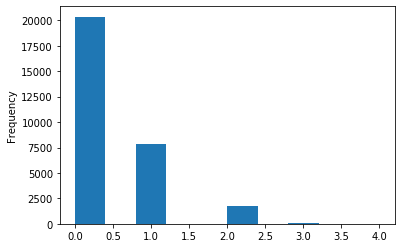

In [12]:
#Showing histogram of 5 equal-width bins
credit['limit_5width'].plot(kind='hist') 

**5 equal-width bin is highly skewed left.** Because 94% of all customers fall into first 2 bins (68% in first bin), this binning technique may not be useful for predicting credit limit.

In [13]:
#rearranging columns to place binned credit limit in front
cols_to_order = credit[['LIMIT_BAL','limit_4','limit_5','limit_5width']]

In [14]:
cols = ([col for col in cols_to_order if col in credit]
       + [col for col in credit if col not in cols_to_order])
credit = credit[cols]

In [15]:
credit.head()

,LIMIT_BAL,limit_4,limit_5,limit_5width,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_4,age_6
0,20000,0,0,0,2,2,1,24,2,2,...,0,0,689,0,0,0,0,1,0,0
1,120000,1,2,0,2,2,2,26,0,2,...,3261,0,1000,1000,1000,0,2000,1,0,0
2,90000,1,1,0,2,2,2,34,0,0,...,15549,1518,1500,1000,1000,1000,5000,0,1,2
3,50000,0,0,0,2,2,1,37,0,0,...,29547,2000,2019,1200,1100,1069,1000,0,2,3
4,50000,0,0,0,1,2,1,57,0,0,...,19131,2000,36681,10000,9000,689,679,0,3,5


In [16]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29965 entries, 0 to 29964
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   LIMIT_BAL     29965 non-null  int64
 1   limit_4       29965 non-null  int32
 2   limit_5       29965 non-null  int32
 3   limit_5width  29965 non-null  int32
 4   SEX           29965 non-null  int64
 5   EDUCATION     29965 non-null  int64
 6   MARRIAGE      29965 non-null  int64
 7   AGE           29965 non-null  int64
 8   PAY_1         29965 non-null  int64
 9   PAY_2         29965 non-null  int64
 10  PAY_3         29965 non-null  int64
 11  PAY_4         29965 non-null  int64
 12  PAY_5         29965 non-null  int64
 13  PAY_6         29965 non-null  int64
 14  BILL_AMT1     29965 non-null  int64
 15  BILL_AMT2     29965 non-null  int64
 16  BILL_AMT3     29965 non-null  int64
 17  BILL_AMT4     29965 non-null  int64
 18  BILL_AMT5     29965 non-null  int64
 19  BILL_AMT6     29965 non-n

#### Feature Selection using Filtering method

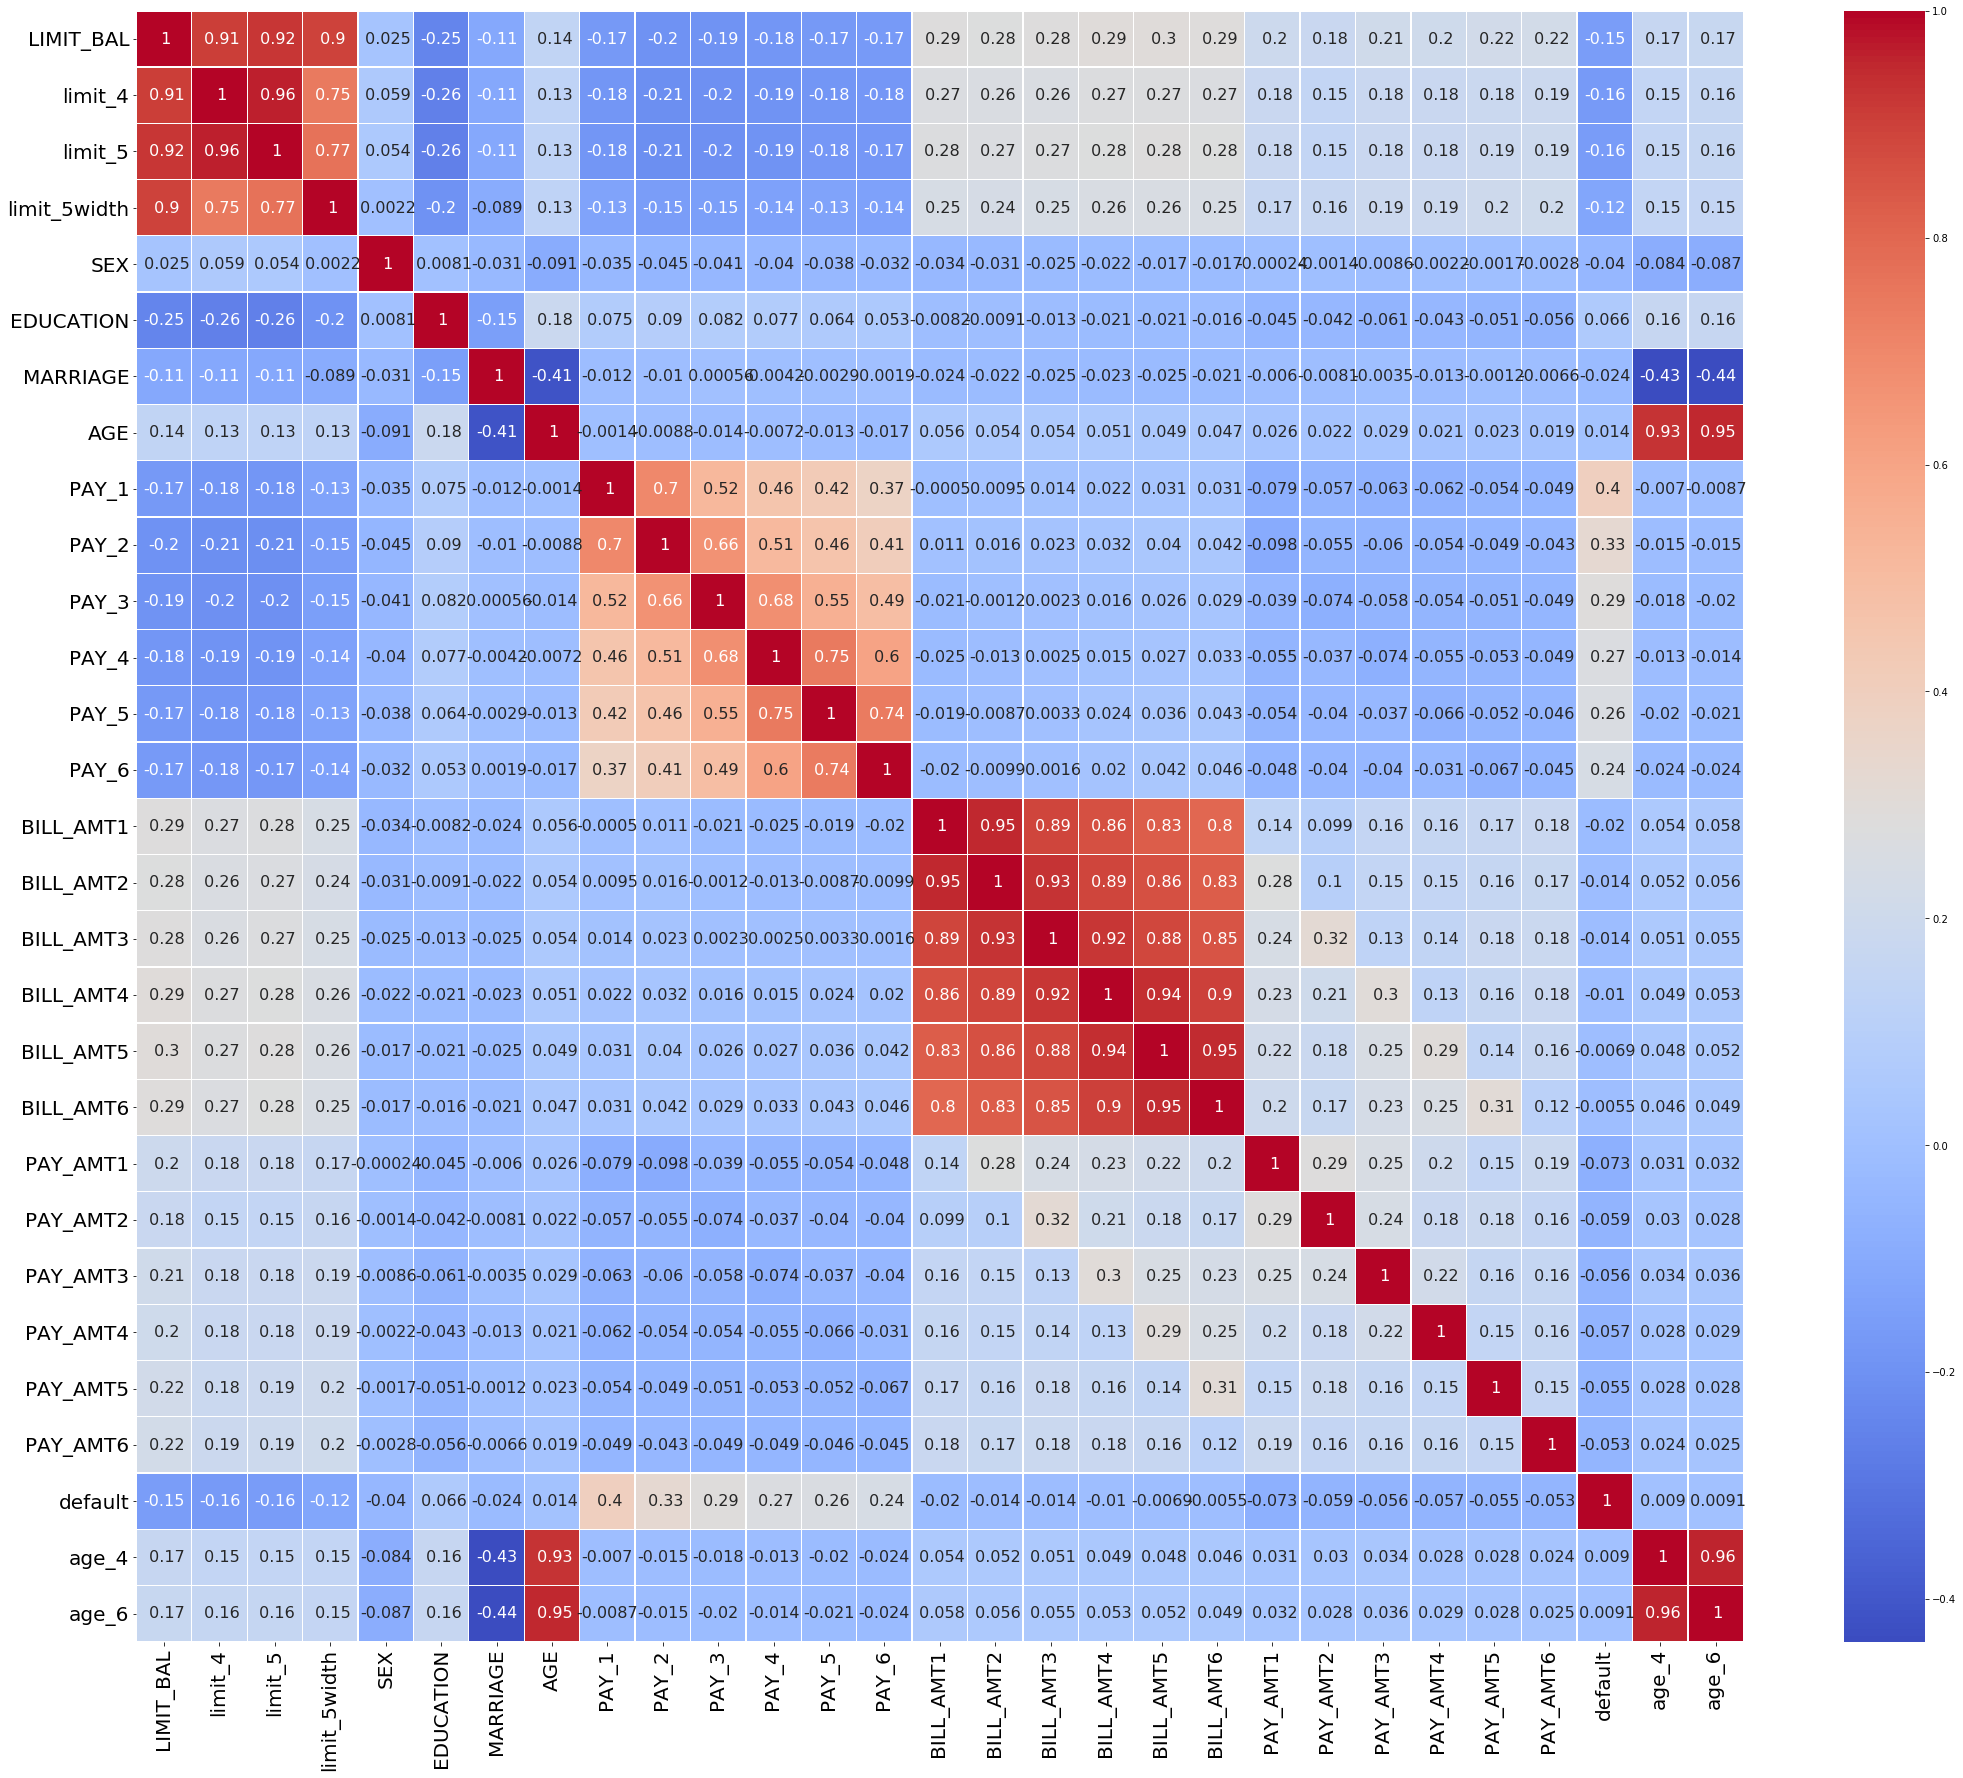

In [17]:
#checking correlation to LIMIT_BAL (target variable)
plt.subplots(figsize=(36,30))
ax = sns.heatmap(credit.corr(), annot = True, annot_kws={'size': 16}, cmap='coolwarm', fmt=' .2g', linewidths = .3)
ax.tick_params(labelsize = 20)

**Findings:** Sex, Age, Marriage, age_4, default, and Pay Statuses have lowest correlation to binned target variables. Remove for second dataframe and reassess correlation matrix.

In [18]:
#dropping unncessary continuous LIMIT_BAL column, since it is not needed for classification algorithms
#dropping redundant continuous Age and age_4 columns, keeping age_6 because it has highest correlation
credit = credit.drop(['LIMIT_BAL','AGE','age_4'], axis=1)
credit.head()

,limit_4,limit_5,limit_5width,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_6
0,0,0,0,2,2,1,2,2,0,0,...,0,0,0,689,0,0,0,0,1,0
1,1,2,0,2,2,2,0,2,0,0,...,3455,3261,0,1000,1000,1000,0,2000,1,0
2,1,1,0,2,2,2,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,0,2
3,0,0,0,2,2,1,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,0,3
4,0,0,0,1,2,1,0,0,0,0,...,19146,19131,2000,36681,10000,9000,689,679,0,5


In [19]:
credit2 = credit.drop(['SEX','MARRIAGE','default','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'],axis=1)
credit2.head()

,limit_4,limit_5,limit_5width,EDUCATION,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,age_6
0,0,0,0,2,3913,3102,689,0,0,0,0,689,0,0,0,0,0
1,1,2,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0
2,1,1,0,2,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,2
3,0,0,0,2,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,3
4,0,0,0,2,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,5


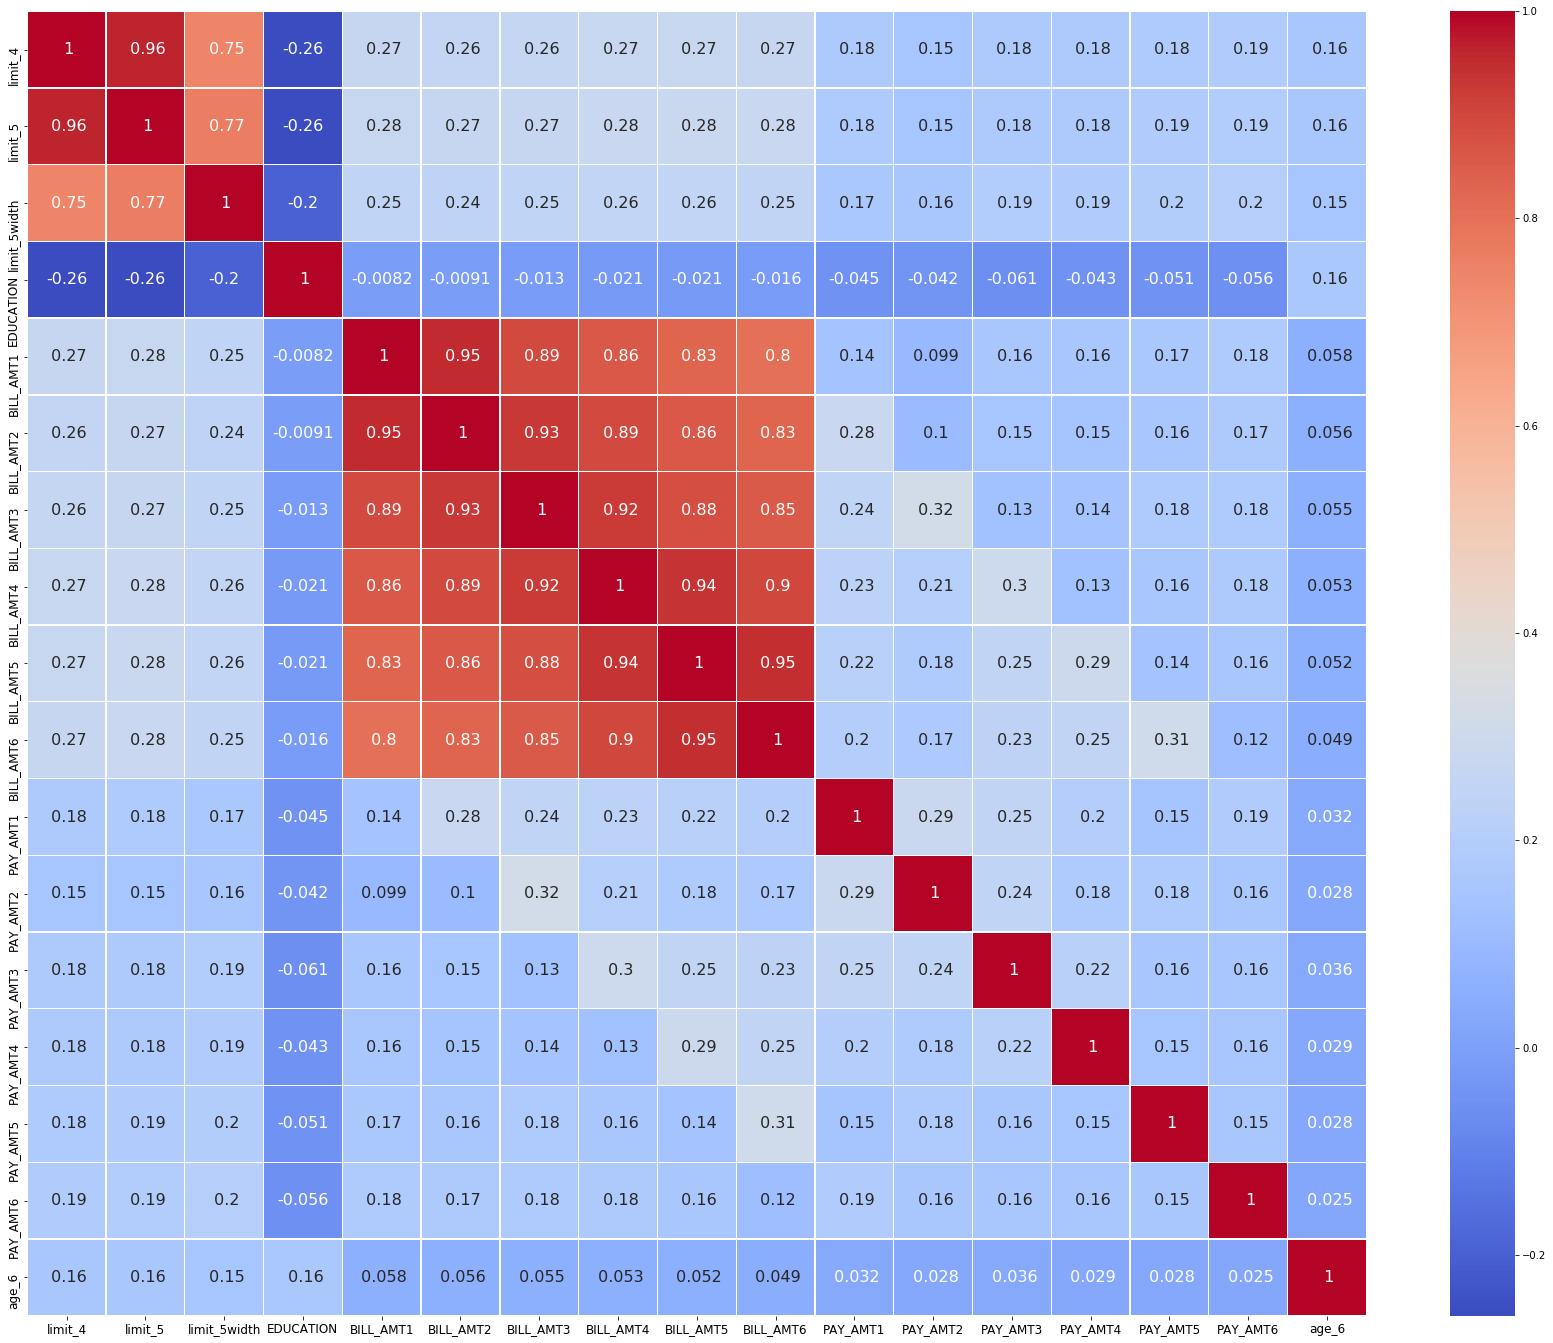

In [20]:
#re-checking correlation to LIMIT_BAL (target variable)
plt.subplots(figsize=(30,24))
ax = sns.heatmap(credit2.corr(), annot = True, annot_kws={'size': 16}, cmap='coolwarm', fmt=' .2g', linewidths = .3)
ax.tick_params(labelsize=12)

**Findings:** Pay statuses and age_6 also have lower correlation to targets, however, will go with this dataframe for classification modeling for now. May utilize additional feature selection during modeling process.

In [21]:
credit3 = credit.drop(['BILL_AMT2','BILL_AMT4','BILL_AMT5'], axis=1)
credit3.head()

,limit_4,limit_5,limit_5width,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_6
0,0,0,0,2,2,1,2,2,0,0,...,689,0,0,689,0,0,0,0,1,0
1,1,2,0,2,2,2,0,2,0,0,...,2682,3261,0,1000,1000,1000,0,2000,1,0
2,1,1,0,2,2,2,0,0,0,0,...,13559,15549,1518,1500,1000,1000,1000,5000,0,2
3,0,0,0,2,2,1,0,0,0,0,...,49291,29547,2000,2019,1200,1100,1069,1000,0,3
4,0,0,0,1,2,1,0,0,0,0,...,35835,19131,2000,36681,10000,9000,689,679,0,5


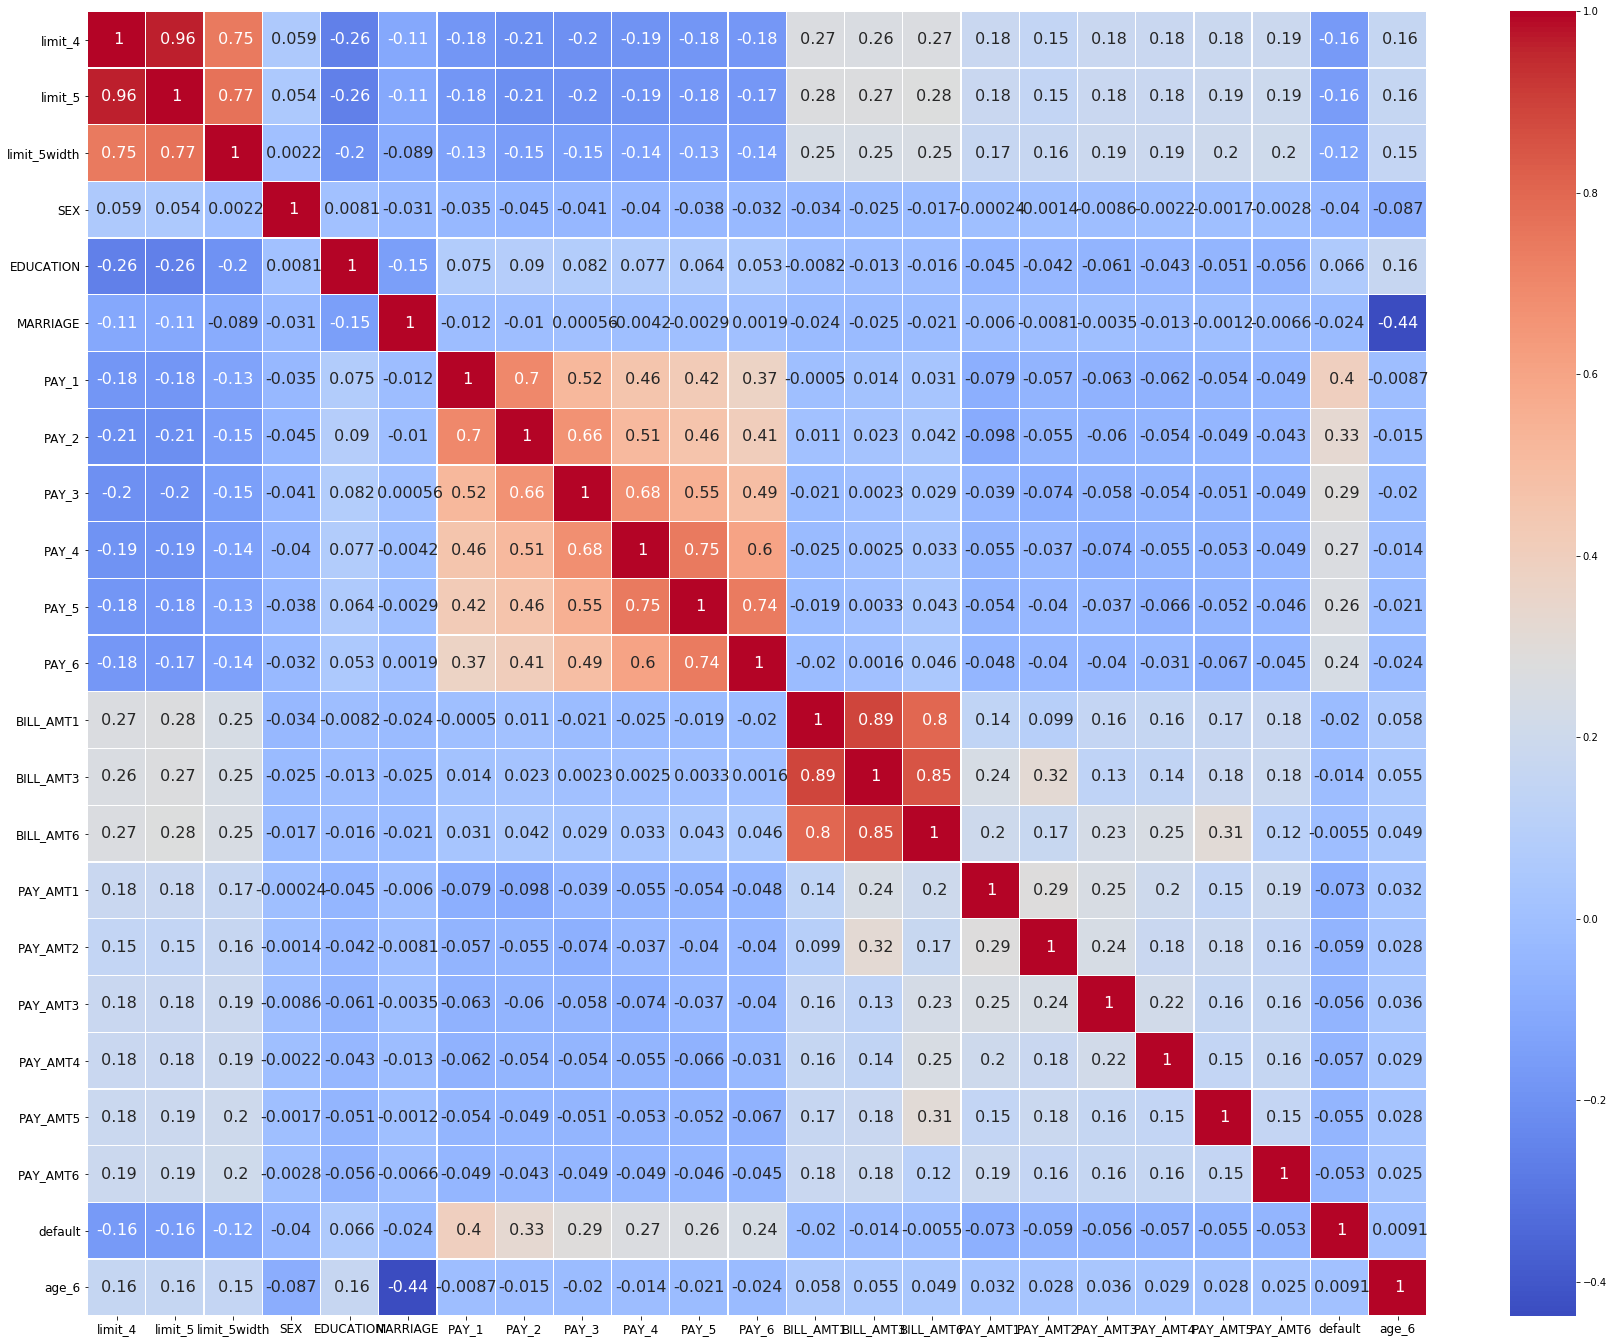

In [22]:
#re-checking correlation to LIMIT_BAL (target variable)
plt.subplots(figsize=(30,24))
ax = sns.heatmap(credit3.corr(), annot = True, annot_kws={'size': 16}, cmap='coolwarm', fmt=' .2g', linewidths = .3)
ax.tick_params(labelsize=12)

### Modeling: Comparing 4 different algorithms

In [34]:
#features
X = credit.iloc[:,3:]

#target variable
y = credit['limit_4']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [35]:
X_train.head()

,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_6
16371,2,3,2,1,2,0,0,0,0,18505,...,18717,17144,0,1800,1600,400,0,0,0,5
137,2,2,1,0,0,0,0,0,0,7166,...,4404,5708,1500,1500,1000,500,2000,546,0,2
12713,1,2,1,0,0,0,0,0,0,14662,...,13721,14492,1500,1300,2000,1000,1000,1000,0,2
10502,1,2,1,2,2,0,0,0,2,117485,...,126102,123914,0,4225,4282,9207,0,4679,1,3
6675,2,1,2,1,2,0,0,0,0,4382,...,5660,0,5,1426,5660,0,0,0,0,0


In [36]:
y_train.head()

16371    0
137      2
12713    0
10502    2
6675     1
Name: limit_4, dtype: int32

In [26]:
algos_Class = []
algos_Class.append(('Random Forest', RandomForestClassifier()))
algos_Class.append(('SVM', SVC()))
algos_Class.append(('Gradient Boosting', GradientBoostingClassifier()))
algos_Class.append(('XGBM', XGBClassifier()))

In [27]:
#Classification
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)

In [28]:
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest 0.5803437378767158
SVM 0.5343234285788055
Gradient Boosting 0.5882863654358333
XGBM 0.5842483132460257


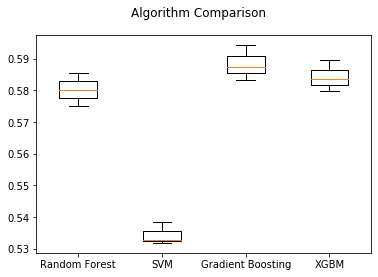

In [29]:
#Box and whisker plot showing spread of accuracy and cross validation scores
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

**Findings:** Accuracy scores were identified for each of 4 classification algorithms right out of the gate. Range of accuracy scores for each bin level are as follows:

1. 4 bins (equal-size): 53-59%
2. 5 bins (equal-size): 44-53%
3. 5 bins (equal-width): 72-74%

**Next step:** Try predicting credit limit with various bins and utilizing tuning methods for top 3 algorithms: **Random Forest Classifier, Gradient Boosting Classifier, and XGBClassifier.**

### Modeling: Random Forest Classification

In [30]:
#Modeling
algo = RandomForestClassifier()

# Parameters currently in use
pprint(algo.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [31]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12]
}

In [32]:
CV_algo = GridSearchCV(estimator=algo, param_grid=param_grid, cv=3, n_jobs=-1)
CV_algo.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [33]:
#Grid Search CV reveals best parameters to use for tuning model
CV_algo.best_params_

{'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 12}

In [37]:
#Modeling
algo = RandomForestClassifier(criterion='entropy', min_samples_leaf=5, min_samples_split=12, n_estimators=600)
model = algo.fit(X_train, y_train)

In [38]:
#Predictions
preds = model.predict(X_test)
#Assessment
print('Accuracy Score is: '), accuracy_score(y_test, preds)

Accuracy Score is: 


(None, 0.5842231713828083)

In [39]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.68      0.84      0.75      1915
           1       0.62      0.52      0.57      1935
           2       0.45      0.46      0.46      1884
           3       0.56      0.50      0.53      1758

    accuracy                           0.58      7492
   macro avg       0.58      0.58      0.58      7492
weighted avg       0.58      0.58      0.58      7492



#### Random Forest top Accuracy Scores with tuning:
1. 4 equal-size bins = 58.4%
2. 5 equal-size bins = 53.5%
3. 5 equal-width bins = 74.2%

### Modeling: Gradient Boosting Classifier

In [40]:
#features
X = credit.iloc[:,3:]

#target variable
y = credit['limit_4']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [41]:
X_train.head()

,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_6
16371,2,3,2,1,2,0,0,0,0,18505,...,18717,17144,0,1800,1600,400,0,0,0,5
137,2,2,1,0,0,0,0,0,0,7166,...,4404,5708,1500,1500,1000,500,2000,546,0,2
12713,1,2,1,0,0,0,0,0,0,14662,...,13721,14492,1500,1300,2000,1000,1000,1000,0,2
10502,1,2,1,2,2,0,0,0,2,117485,...,126102,123914,0,4225,4282,9207,0,4679,1,3
6675,2,1,2,1,2,0,0,0,0,4382,...,5660,0,5,1426,5660,0,0,0,0,0


In [42]:
y_train.head()

16371    0
137      2
12713    0
10502    2
6675     1
Name: limit_4, dtype: int32

In [43]:
gbc = GradientBoostingClassifier()
# Parameters currently in use
pprint(gbc.get_params())

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [44]:
param_grid = {
    'max_features': [5, 8, 12],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12]
}

In [45]:
CV_algo = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3, n_jobs=-1)
CV_algo.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [46]:
#Grid Search CV reveals best parameters to use for tuning model
CV_algo.best_params_

{'max_depth': 5,
 'max_features': 12,
 'min_samples_leaf': 5,
 'min_samples_split': 10}

In [47]:
# Modeling, tuning hyperparameters
gbc = GradientBoostingClassifier(max_depth=5, max_features=12, min_samples_leaf=5, min_samples_split=10)
model = gbc.fit(X_train, y_train)

In [48]:
# Predictions
preds = model.predict(X_test)
print('Accuracy on CV data: '), accuracy_score(y_test, preds)

Accuracy on CV data: 


(None, 0.5868926855312333)

In [49]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.70      0.82      0.75      1915
           1       0.60      0.54      0.57      1935
           2       0.45      0.48      0.46      1884
           3       0.58      0.51      0.54      1758

    accuracy                           0.59      7492
   macro avg       0.58      0.58      0.58      7492
weighted avg       0.58      0.59      0.58      7492



In [50]:
#features
X = credit.iloc[:,3:]

#target variable
y = credit['limit_5']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [51]:
X_train.head()

,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_6
16371,2,3,2,1,2,0,0,0,0,18505,...,18717,17144,0,1800,1600,400,0,0,0,5
137,2,2,1,0,0,0,0,0,0,7166,...,4404,5708,1500,1500,1000,500,2000,546,0,2
12713,1,2,1,0,0,0,0,0,0,14662,...,13721,14492,1500,1300,2000,1000,1000,1000,0,2
10502,1,2,1,2,2,0,0,0,2,117485,...,126102,123914,0,4225,4282,9207,0,4679,1,3
6675,2,1,2,1,2,0,0,0,0,4382,...,5660,0,5,1426,5660,0,0,0,0,0


In [52]:
y_train.head()

16371    0
137      3
12713    0
10502    2
6675     2
Name: limit_5, dtype: int32

In [53]:
# Modeling, tuning hyperparameters
gbc = GradientBoostingClassifier(max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=400)
model = gbc.fit(X_train, y_train)

In [54]:
# Predictions
preds = model.predict(X_test)
print('Accuracy on CV data: '), accuracy_score(y_test, preds)

Accuracy on CV data: 


(None, 0.5281633742658836)

In [55]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.68      0.83      0.75      1915
           1       0.50      0.45      0.48      1198
           2       0.43      0.41      0.42      1552
           3       0.37      0.30      0.33      1363
           4       0.51      0.54      0.52      1464

    accuracy                           0.53      7492
   macro avg       0.50      0.51      0.50      7492
weighted avg       0.51      0.53      0.52      7492



In [56]:
#features
X = credit.iloc[:,3:]

#target variable
y = credit['limit_5width']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [57]:
X_train.head()

,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_6
16371,2,3,2,1,2,0,0,0,0,18505,...,18717,17144,0,1800,1600,400,0,0,0,5
137,2,2,1,0,0,0,0,0,0,7166,...,4404,5708,1500,1500,1000,500,2000,546,0,2
12713,1,2,1,0,0,0,0,0,0,14662,...,13721,14492,1500,1300,2000,1000,1000,1000,0,2
10502,1,2,1,2,2,0,0,0,2,117485,...,126102,123914,0,4225,4282,9207,0,4679,1,3
6675,2,1,2,1,2,0,0,0,0,4382,...,5660,0,5,1426,5660,0,0,0,0,0


In [58]:
y_train.head()

16371    0
137      1
12713    0
10502    0
6675     0
Name: limit_5width, dtype: int32

In [59]:
# Modeling, tuning hyperparameters
gbc = GradientBoostingClassifier(n_estimators=400)
model = gbc.fit(X_train, y_train)

In [60]:
# Predictions
preds = model.predict(X_test)
print('Accuracy on CV data: '), accuracy_score(y_test, preds)

Accuracy on CV data: 


(None, 0.7429257875066738)

In [61]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      5101
           1       0.56      0.47      0.51      1938
           2       0.55      0.15      0.24       432
           3       0.00      0.00      0.00        21

    accuracy                           0.74      7492
   macro avg       0.48      0.38      0.40      7492
weighted avg       0.72      0.74      0.72      7492



#### Gradient Boosting top Accuracy Scores with tuning:
1. 4 equal-size bins = 58.5%
2. 5 equal-size bins = 53%
3. 5 equal-width bins = 74.2%

### Modeling: Xtreme Gradient Boosting Classifier

In [62]:
#features
X = credit.iloc[:,3:]

#target variable
y = credit['limit_4']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [63]:
X_train.head()

,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_6
16371,2,3,2,1,2,0,0,0,0,18505,...,18717,17144,0,1800,1600,400,0,0,0,5
137,2,2,1,0,0,0,0,0,0,7166,...,4404,5708,1500,1500,1000,500,2000,546,0,2
12713,1,2,1,0,0,0,0,0,0,14662,...,13721,14492,1500,1300,2000,1000,1000,1000,0,2
10502,1,2,1,2,2,0,0,0,2,117485,...,126102,123914,0,4225,4282,9207,0,4679,1,3
6675,2,1,2,1,2,0,0,0,0,4382,...,5660,0,5,1426,5660,0,0,0,0,0


In [64]:
y_train.head()

16371    0
137      2
12713    0
10502    2
6675     1
Name: limit_4, dtype: int32

In [65]:
xgbc = XGBClassifier()
# Parameters currently in use
pprint(gbc.get_params())

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [66]:
param_grid = {
    'max_features': [5, 8, 12],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 3]
}

In [67]:
CV_algo = GridSearchCV(estimator=xgbc, param_grid=param_grid, cv=3, n_jobs=-1)
CV_algo.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=Non

In [68]:
#Grid Search CV reveals best parameters to use for tuning model
CV_algo.best_params_

{'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 1}

In [69]:
# Modeling, tuning hyperparameters
xgbc = XGBClassifier()
model = xgbc.fit(X_train, y_train)

In [70]:
# Predictions
preds = model.predict(X_test)
print('Accuracy on CV data: '), accuracy_score(y_test, preds)

Accuracy on CV data: 


(None, 0.5903630539241858)

In [71]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.71      0.82      0.76      1915
           1       0.61      0.55      0.58      1935
           2       0.45      0.46      0.45      1884
           3       0.58      0.53      0.55      1758

    accuracy                           0.59      7492
   macro avg       0.59      0.59      0.59      7492
weighted avg       0.59      0.59      0.59      7492



In [72]:
#features
X = credit.iloc[:,3:]

#target variable
y = credit['limit_5']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [73]:
X_train.head()

,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_6
16371,2,3,2,1,2,0,0,0,0,18505,...,18717,17144,0,1800,1600,400,0,0,0,5
137,2,2,1,0,0,0,0,0,0,7166,...,4404,5708,1500,1500,1000,500,2000,546,0,2
12713,1,2,1,0,0,0,0,0,0,14662,...,13721,14492,1500,1300,2000,1000,1000,1000,0,2
10502,1,2,1,2,2,0,0,0,2,117485,...,126102,123914,0,4225,4282,9207,0,4679,1,3
6675,2,1,2,1,2,0,0,0,0,4382,...,5660,0,5,1426,5660,0,0,0,0,0


In [74]:
y_train.head()

16371    0
137      3
12713    0
10502    2
6675     2
Name: limit_5, dtype: int32

In [75]:
# Modeling, tuning hyperparameters
xgbc = XGBClassifier(max_depth=3, max_features=5, min_sample_leaf=1, n_estimators=400)
model = xgbc.fit(X_train, y_train)

In [76]:
# Predictions
preds = model.predict(X_test)
print('Accuracy on CV data: '), accuracy_score(y_test, preds)

Accuracy on CV data: 


(None, 0.5242925787506674)

In [77]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.68      0.84      0.75      1915
           1       0.51      0.45      0.48      1198
           2       0.44      0.39      0.41      1552
           3       0.36      0.30      0.32      1363
           4       0.50      0.53      0.51      1464

    accuracy                           0.52      7492
   macro avg       0.50      0.50      0.50      7492
weighted avg       0.51      0.52      0.51      7492



In [78]:
#features
X = credit.iloc[:,3:]

#target variable
y = credit['limit_5width']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [79]:
X_train.head()

,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_6
16371,2,3,2,1,2,0,0,0,0,18505,...,18717,17144,0,1800,1600,400,0,0,0,5
137,2,2,1,0,0,0,0,0,0,7166,...,4404,5708,1500,1500,1000,500,2000,546,0,2
12713,1,2,1,0,0,0,0,0,0,14662,...,13721,14492,1500,1300,2000,1000,1000,1000,0,2
10502,1,2,1,2,2,0,0,0,2,117485,...,126102,123914,0,4225,4282,9207,0,4679,1,3
6675,2,1,2,1,2,0,0,0,0,4382,...,5660,0,5,1426,5660,0,0,0,0,0


In [80]:
y_train.head()

16371    0
137      1
12713    0
10502    0
6675     0
Name: limit_5width, dtype: int32

In [81]:
# Modeling, tuning hyperparameters
xgbc = XGBClassifier(max_depth=3, max_features=5, min_sample_leaf=1, n_estimators=400)
model = xgbc.fit(X_train, y_train)

In [82]:
# Predictions
preds = model.predict(X_test)
print('Accuracy on CV data: '), accuracy_score(y_test, preds)

Accuracy on CV data: 


(None, 0.7421249332621462)

In [83]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      5101
           1       0.55      0.47      0.51      1938
           2       0.54      0.17      0.25       432
           3       0.00      0.00      0.00        21

    accuracy                           0.74      7492
   macro avg       0.47      0.38      0.40      7492
weighted avg       0.72      0.74      0.72      7492



#### Xtreme Gradient Boosting top Accuracy Scores with tuning:
1. 4 equal-size bins = 59%
2. 5 equal-size bins = 52.4%
3. 5 equal-width bins = 74.2%

### Top Accuracy Score with 4 equal-sized bins: 59% (Xtreme Gradient Boosting)

### Top Accuracy Score with 5 equal-sized bins: 53.5% (Random Forest Classifier)

**Top Accuracy Score with 5 equal-width bins:** 74.3% (Gradient Boosting Classifier), however, this bin technique may not be useful as the distribution is highly skewed in first (10,000-200,000) and second (200,000-400,000) credit limit groups.

### Conclusion:
This notebook set out to try to predict categorical credit limit. Credit limit was binned into the following categories: 4 equal-sized bins, 5 equal-sized bins, and 5 equal-width bins. Cross_val_score was utilized on each of 4 different machine learning algorithms, the top 3 determined to be Random Forest Classifier, Gradient Boosting Classifier, and Xtreme Gradient Boosting Classifier. Feature selection was utilized along with hyperparameter tuning on each algorithm for the top 3 algorithms on each binned credit limit group. The following results were achieved:

1. Between 4 and 5 equal-sized credit limit categories, 4 bins produced the highest accuracy of predicting credit limit at 59% (vs. 53% for 5 credit limit groups). This is slightly better than an educated guess. It is possible that more and/or better data is needed to improve the accuracy of predicting credit limit for future customers.
2. Binning into 5 equal-width bins produced the highest accuracy level overall, at 74.3%. However, because the distribution of this method is highly skewed (68% in 10,000-200,000 and 26% in 200,000 to 400,000) this method is not recommended as an effective strategy for predicting credit limit for future customers.

### Exploring Predictions with Non-Defaulters Only - just for fun

In [89]:
nonDefault = credit[credit.default==0]
nonDefault.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23335 entries, 2 to 29961
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   limit_4       23335 non-null  int32
 1   limit_5       23335 non-null  int32
 2   limit_5width  23335 non-null  int32
 3   SEX           23335 non-null  int64
 4   EDUCATION     23335 non-null  int64
 5   MARRIAGE      23335 non-null  int64
 6   PAY_1         23335 non-null  int64
 7   PAY_2         23335 non-null  int64
 8   PAY_3         23335 non-null  int64
 9   PAY_4         23335 non-null  int64
 10  PAY_5         23335 non-null  int64
 11  PAY_6         23335 non-null  int64
 12  BILL_AMT1     23335 non-null  int64
 13  BILL_AMT2     23335 non-null  int64
 14  BILL_AMT3     23335 non-null  int64
 15  BILL_AMT4     23335 non-null  int64
 16  BILL_AMT5     23335 non-null  int64
 17  BILL_AMT6     23335 non-null  int64
 18  PAY_AMT1      23335 non-null  int64
 19  PAY_AMT2      23335 non-n

In [90]:
nonDefault.head()

,limit_4,limit_5,limit_5width,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_6
2,1,1,0,2,2,2,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,0,2
3,0,0,0,2,2,1,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,0,3
4,0,0,0,1,2,1,0,0,0,0,...,19146,19131,2000,36681,10000,9000,689,679,0,5
5,0,0,0,1,1,2,0,0,0,0,...,19619,20024,2500,1815,657,1000,1000,800,0,3
6,3,4,2,1,1,2,0,0,0,0,...,483003,473944,55000,40000,38000,20239,13750,13770,0,1


In [91]:
#rearranging columns to place binned credit limit in front
cols_to_order = nonDefault[['default']]

In [93]:
cols = ([col for col in cols_to_order if col in nonDefault]
       + [col for col in nonDefault if col not in cols_to_order])
nonDefault = nonDefault[cols]

In [94]:
nonDefault.head()

,default,limit_4,limit_5,limit_5width,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,age_6
2,0,1,1,0,2,2,2,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,2
3,0,0,0,0,2,2,1,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,3
4,0,0,0,0,1,2,1,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,5
5,0,0,0,0,1,1,2,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,3
6,0,3,4,2,1,1,2,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,1


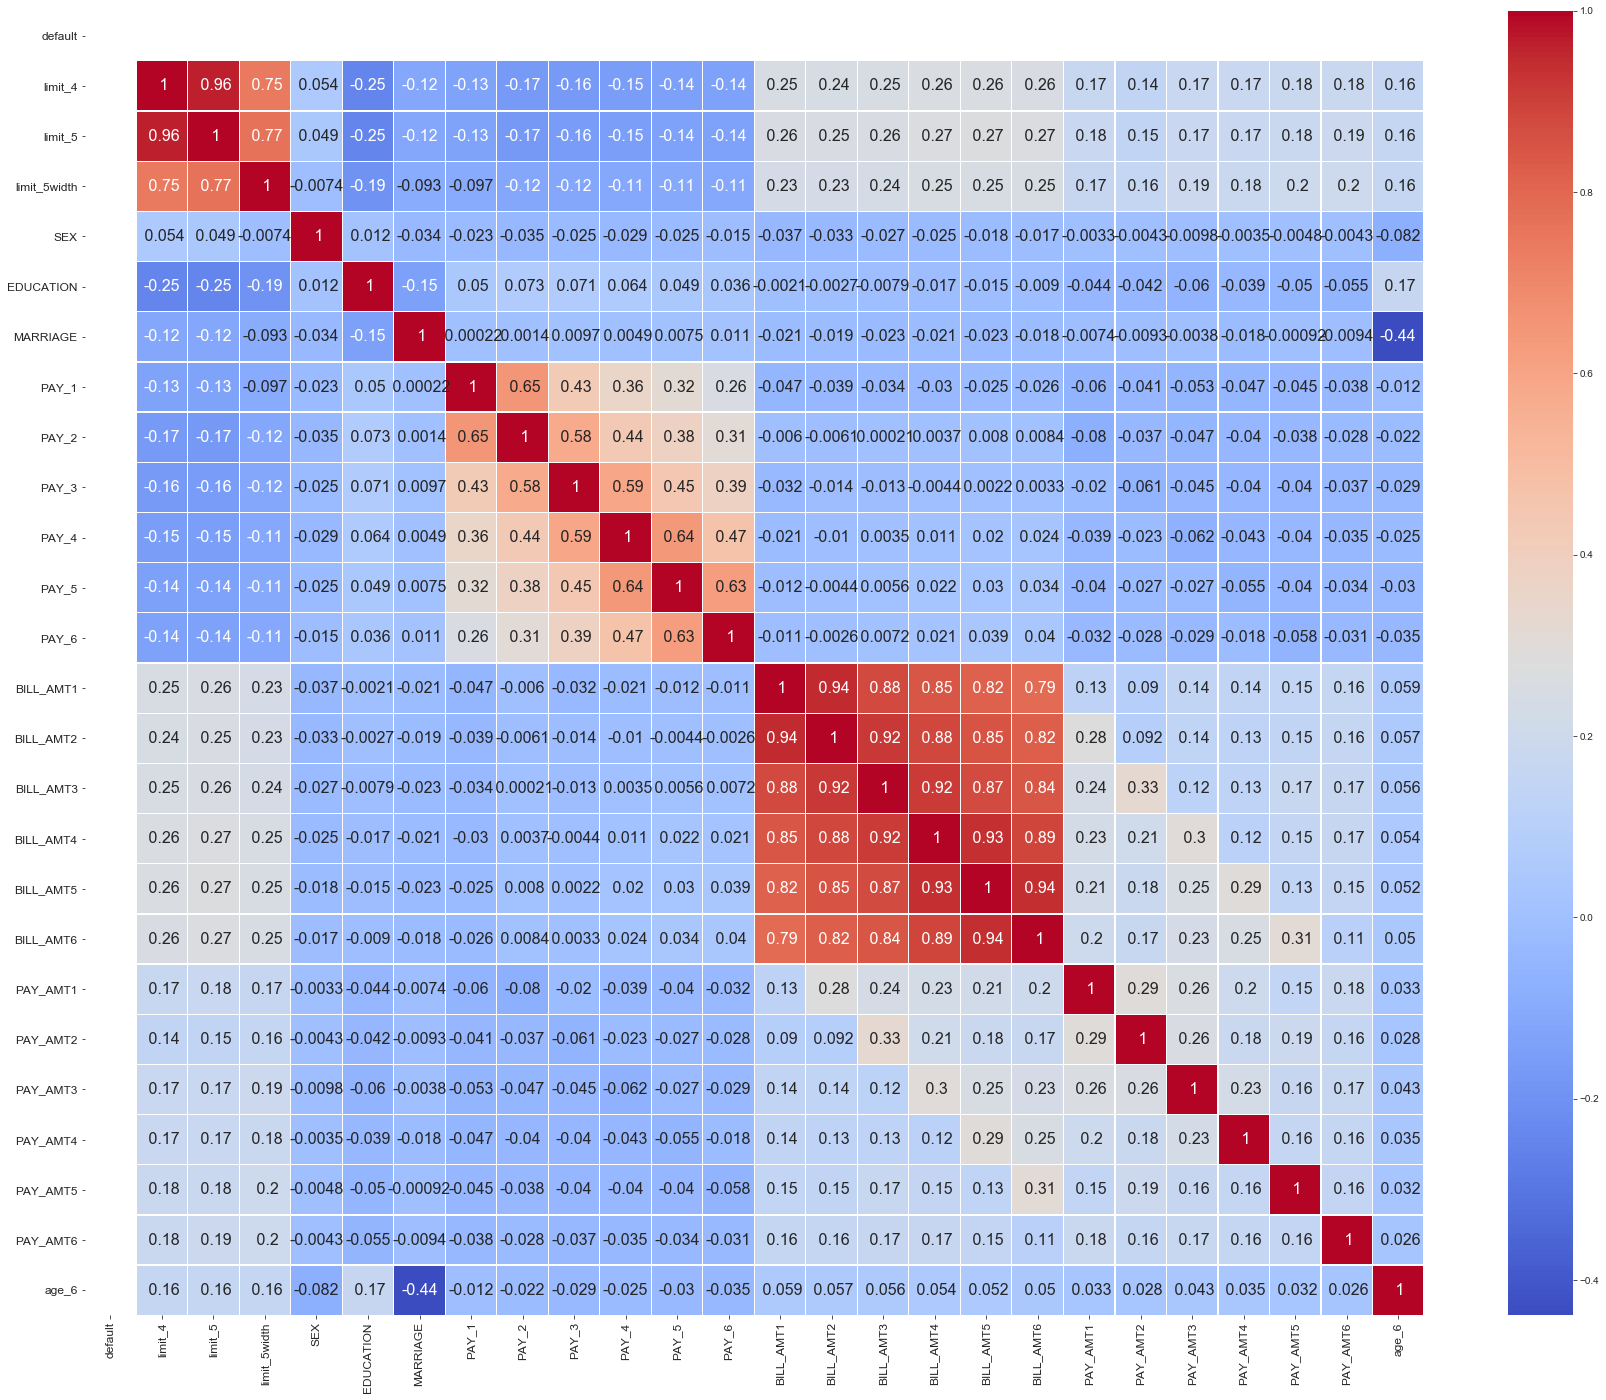

In [100]:
#re-checking correlation
plt.subplots(figsize=(30,24))
ax = sns.heatmap(nonDefault.corr(), annot = True, annot_kws={'size': 16}, cmap='coolwarm', fmt=' .2g', linewidths = .3)
ax.tick_params(labelsize=12)

In [97]:
#features
X = nonDefault.iloc[:,4:]

#target variable
y = nonDefault['limit_4']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [98]:
X_train.head()

,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,age_6
9470,1,1,2,1,0,0,0,0,0,0,...,0,0,478,1422,0,0,0,478,0,3
9593,2,1,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24450,1,2,1,0,0,0,0,0,0,9288,...,13310,3539,2926,17095,28824,13367,3547,2936,9580,3
26490,2,2,2,0,0,0,0,0,0,16503,...,15495,15938,16680,1289,1258,1260,700,1000,2100,5
7625,1,1,1,0,0,0,0,0,0,325,...,580,9664,29200,325,325,580,9664,29200,5260,3


In [99]:
y_train.head()

9470     2
9593     3
24450    3
26490    0
7625     3
Name: limit_4, dtype: int32

In [101]:
algos_Class = []
algos_Class.append(('Random Forest', RandomForestClassifier()))
algos_Class.append(('SVM', SVC()))
algos_Class.append(('Gradient Boosting', GradientBoostingClassifier()))
algos_Class.append(('XGBM', XGBClassifier()))

In [102]:
#Classification
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)

In [103]:
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest 0.553117555684845
SVM 0.5148489834894585
Gradient Boosting 0.5673022586661151
XGBM 0.5627596965908958


In [105]:
param_grid = {
    'max_features': [5, 8, 12],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12]
}

In [ ]:
CV_algo = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3, n_jobs=-1)
CV_algo.fit(X_train, y_train)

In [ ]:
#Grid Search CV reveals best parameters to use for tuning model
CV_algo.best_params_

In [ ]:
# Modeling, tuning hyperparameters
gbc = GradientBoostingClassifier(max_depth=5, max_features=8, min_samples_leaf=5, min_samples_split=10, n_estimators=400)
model = gbc.fit(X_train, y_train)